In [1]:
'''
IMPORTS 
'''

import pandas as pd
from scipy.fftpack import fft
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as s
import os
import pywt

In [2]:

## Once for a dataset
##################################################################

'''
This replaces every i to j and converts to a complex no.
'''
def replace_ij(df):
    for tits in df.columns:
        if(tits != 'File'):
        
            if df[tits].dtypes =='O':
                df[tits] = df[tits].str.replace('i','j')
                df[tits] = df[tits].str.replace(' ','')
                df[tits] = df[tits].apply(lambda x: np.complex(x))
                
    return df

'''
This finds the magnitude of every complex no.
'''
def find_mag(df): #### creating magnitude 
    for tits in df.columns:
        if(tits != 'File'):
            
            df[tits] = np.round(np.abs(df[tits]),decimals = 2)
            
            if df[tits].dtypes =='O':
                print("hi")
                
    return df
'''
This imports the magnitudes into a csv file and creates in the final dir. 
'''
def convert_to_mag(initial_path,final_path):
    '''
    This iterates over every csv in the inital_path and then outputs the mag_csv to final_path.
    '''
    
    directory = initial_path
    z = directory + "/"
    
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            a = z + filename
            print('Under Progress',filename)
            df = pd.read_csv(a)
            print(len(df.columns))
            if (len(df.columns) == 90):
                df.columns = ['a_1','b_1','c_1','a_2','b_2','c_2','a_3','b_3','c_3','a_4','b_4','c_4','a_5','b_5','c_5','a_6','b_6','c_6','a_7','b_7','c_7','a_8','b_8','c_8','a_9','b_9','c_9','a_10','b_10','c_10','a_11','b_11','c_11','a_12','b_12','c_12','a_13','b_13','c_13','a_14','b_14','c_14','a_15','b_15','c_15','a_16','b_16','c_16','a_17','b_17','c_17','a_18','b_18','c_18','a_19','b_19','c_19','a_20','b_20','c_20','a_21','b_21','c_21','a_22','b_22','c_22','a_23','b_23','c_23','a_24','b_24','c_24','a_25','b_25','c_25','a_26','b_26','c_26','a_27','b_27','c_27','a_28','b_28','c_28','a_29','b_29','c_29','a_30','b_30','c_30']
            
            
            
            df = replace_ij(df)
            df = find_mag(df)
        
            target_name = final_path + filename

            print('done')
            
            
            df.to_csv(target_name,index=False)
            
    print("All CSV's DONE !!")
    
init1 = '/home/surya/Desktop/wifi_sensing/final/1_BHK_rawdata/act'
init2 = '/home/surya/Desktop/wifi_sensing/final/1_BHK_rawdata/noact'

final1 = '/home/surya/Desktop/wifi_sensing/final/1_BHK_mag_data/act/'
final2 = '/home/surya/Desktop/wifi_sensing/final/1_BHK_mag_data/noact/'

convert_to_mag(init2,final2)
convert_to_mag(init1,final1)



FileNotFoundError: [Errno 2] No such file or directory: '/home/surya/Desktop/wifi_sensing/final/1_BHK_rawdata/noact'

In [40]:
'''
This downsamples the csv file content with dsr: DOWN SAMPLING RATIO.
'''
def create_downsample(dsr,samples,csv,col_name):
    
    df = pd.read_csv(csv,usecols=col_name)
    length =  df.shape[1] ## 30 subcarriers
    total = []
    
    temp = np.zeros((30000,length))
    temp = np.array(df[:samples])
    
    trans = np.transpose(temp)
    
    down_sampled = np.zeros((length,int(samples/dsr)),dtype = float)
      
    for row in range(0,dsr):
        down_sampled = trans[:,row::dsr]
        total.append(down_sampled)
    #print("The shape of desampled list :",np.shape(total))
    return total
   
##########################################################
'''
 below code is for returning the list of col_names [b_1.....b_30]
'''

names =[]
for i in range(1,31):
    temp = str("c_" + str(i))
    names.append(temp)
#print(names)



'''
This converts the (16,30,1875) to (172,30,300), default = 16
WITH AN OVERLAPPING WINDOW OF 50%
'''
def part_time_slice(arr,size = 300,overlap_per = 50):

    start = int(0)
    stop = int(start+size)
    temp = arr
    list1 = []
    while(stop <= arr.shape[1]):## arr.shape[1] == 1875. 
        datapoint = np.zeros((30,size))
        datapoint = np.array(temp[:,start:stop],dtype=float)
        #print("This is datapoint")
        #print(np.shape(datapoint))
        list1.append(datapoint)
        start =int( start+((100-overlap_per)*0.01*size))
        stop = int(start  +size)
    return list1 
'''
Joins every small part to the whole
'''

def total_time_parse(sliced_list,dsr = 16):
    time_parse_list = []
    for itr in range(dsr):
        temp = (sliced_list[itr])
        #print("The shape of temp is ", np.shape(temp))
        list_son = part_time_slice(temp)
        
        #print("The dimension of list_son is :", np.shape(list_son))
        
        time_parse_list.extend(list_son)
        
    return time_parse_list

'''
Performs wavelet denoising !!!

http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
'''

def denoise(signal, thresh ,title = None, wavelet="db5"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    #print(np.shape(coeff))
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return  np.round(reconstructed_signal,decimals = 2)

def preprocess(datapoint,thresh = 0.35):
    dummy = np.zeros(datapoint.shape)
    for car in range(30):
        dummy[car,:] = denoise(datapoint[car,:],thresh) 
    return dummy


In [4]:
'''
This is to find out the features for every chunk i.e 300*30 matrix.
'''

cols = ['b_1','b_2','b_3','b_4','b_5','b_6','b_7','b_8','b_9','b_10','b_11','b_12','b_13','b_14','b_15','b_16','b_17','b_18','b_19','b_20','b_21','b_22','b_23','b_24','b_25','b_26','b_27','b_28','b_29','b_30']
def heat_map(array):
    plt.figure(figsize=(20,20))
    sns.set(font_scale=1.5)
    hm = sns.heatmap(array,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size': 12},yticklabels=cols,xticklabels=cols)
    plt.tight_layout()
    plt.show()

def normalixing_matrix(arr): ## array should be 300*30
    normed =(arr - arr.mean(axis=0)) / arr.std(axis=0)
    #print("The shape of normed is", normed.shape)
    cov = np.cov(normed.T)
    return normed,cov

def eigendecomposition(array,k):
    eig_values, eig_vectors = np.linalg.eig(array)
    idx = np.argsort(eig_values, axis=0)[::-1]
    sorted_eig_vectors = eig_vectors[:, idx]
    cumsum = np.cumsum(eig_values[idx]) / np.sum(eig_values[idx])
    xint = range(1, len(cumsum) + 1)
    '''
    plt.figure(figsize = (10,10))
    plt.plot(xint, cumsum)
    plt.xlabel("Number of components")
    plt.ylabel("Cumulative explained variance")
    plt.xticks(xint)
    plt.xlim(1, 30, 1)
    '''
    req_eig_vectors = sorted_eig_vectors[:, 0:k]
    return req_eig_vectors

def diff(array):
    sum = 0
    for i in range(1,len(array)):
        sum = sum + abs(array[i] - array[i-1])
    sum = sum / len(array)-1
    return sum

def extractfeatures(array):
    lis = np.zeros(array.shape[1])
    for i in range(array.shape[1]):
        temp = array[:,i]
        lis[i] = diff(temp)
    return lis
        

'''
This is the summary of all codes above !!
'''




def feature_produce(chunk):# chunk shoould be 30*300
    trans = chunk.T
    normed,cov = normalixing_matrix(trans)
    req_eig_vectors = eigendecomposition(cov,5)
    features= extractfeatures(req_eig_vectors)
    return features

In [5]:
one = '/home/surya/Desktop/wifi_sensing/final/1bhk_folder/1_BHK_mag_data/noact/input_noactivity_1.csv'

dsr= 16 
samples = 30000

sliced_list = create_downsample(dsr,samples,one,names)
time_parse_list = total_time_parse(sliced_list)
## This time parse list is for each 

#denoised = denoise(time_parse_list, 0.3 ,title = None, wavelet="db5")
print("The shape after time parsing : ",np.shape(time_parse_list))

The shape after time parsing :  (176, 30, 300)


In [6]:
gf = pd.DataFrame()
son = np.array(time_parse_list)
filename = str("walk_d6e5_2")
target = 1

content_csv = []
for itr in range(son.shape[0]):
    row = []
    title = filename + "(" + str(itr) + ")"
    feat = np.round(feature_produce(son[itr]),decimals = 3)
    row.append(title)
    row.extend(feat)
    row.append(target)
    
    #print(row)
    content_csv.append(row)
    
#print(content_csv) 
gf =gf.append(content_csv)
print(gf.head)

<bound method NDFrame.head of                     0      1      2      3      4      5  6
0      walk_d6e5_2(0) -0.830 -0.850 -0.791 -0.814 -0.809  1
1      walk_d6e5_2(1) -0.850 -0.792 -0.787 -0.830 -0.813  1
2      walk_d6e5_2(2) -0.806 -0.792 -0.786 -0.809 -0.804  1
3      walk_d6e5_2(3) -0.803 -0.783 -0.821 -0.781 -0.790  1
4      walk_d6e5_2(4) -0.776 -0.816 -0.817 -0.834 -0.797  1
..                ...    ...    ...    ...    ...    ... ..
171  walk_d6e5_2(171) -0.892 -0.820 -0.809 -0.795 -0.810  1
172  walk_d6e5_2(172) -0.820 -0.804 -0.780 -0.843 -0.771  1
173  walk_d6e5_2(173) -0.816 -0.812 -0.813 -0.831 -0.789  1
174  walk_d6e5_2(174) -0.786 -0.834 -0.823 -0.855 -0.829  1
175  walk_d6e5_2(175) -0.820 -0.804 -0.777 -0.840 -0.763  1

[176 rows x 7 columns]>


In [7]:
def create_dad(csv,target,title,dsr= 16 ,samples = 30000):
    dad = pd.DataFrame()
    sliced_list = create_downsample(dsr,samples,csv,names)
    time_parse_list = total_time_parse(sliced_list) ## This time parse list is for each 
    print("The shape after time parsing : ",np.shape(time_parse_list))
    
    son = np.array(time_parse_list)
    filename = title
    content_csv = []
    for itr in range(son.shape[0]):
        row = []
        title = filename + "(" + str(itr) + ")"
        feat = np.round(feature_produce(son[itr]),decimals = 3)
        row.append(title)
        row.extend(feat)
        row.append(target)
        content_csv.append(row)
    dad =dad.append(content_csv)
    #print(dad.head)
        
        
    return dad
    

In [8]:
def create_godfather(dataframe,target):
    if(target == 0):
        GF = dataframe
        directory = '/home/surya/Desktop/wifi_sensing/final/1_BHK_mag_data/noact'
        z = directory + "/"
    else:
        GF = dataframe
        directory = '/home/surya/Desktop/wifi_sensing/final/1_BHK_mag_data/act'
        z = directory + "/"
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            a = z + filename
# <><><><><><><><><><><><><><><><><><><><><><><><><><>

#This is for deciding the title


        if(target == 0):
            sstring1 = '/home/surya/Desktop/wifi_sensing/final/1_BHK_mag_data/noact/input_noactivity'
            res = a.replace(sstring1, 'no_act') 
        else:
            sstring1 = '/home/surya/Desktop/wifi_sensing/final/1_BHK_mag_data/act/input_walk_'
            res = a.replace(sstring1, '') 
                
        sstring2 = '.csv'
        title = res.replace(sstring2, '') 
            
        print('Under Progress',title)
        content_one_csv = create_dad(a,target,title)
        GF = GF.append(content_one_csv)
        
#<><><><><><><><><><><><><><><><><><><><><><><><><><>
    return GF

GF = pd.DataFrame()
GF = create_godfather(GF,0)
GF = create_godfather(GF,1)
print(GF.head())
print(len(GF.columns))
if (len(GF.columns) == 7):
    GF.columns = ['title','A_1','A_2','A_3','A_4','A_5','Y']
GF.to_csv("SVM_features_1BHK_C.csv",index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/surya/Desktop/wifi_sensing/final/1_BHK_mag_data/noact'

The shape after time parsing :  (176, 30, 300)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)


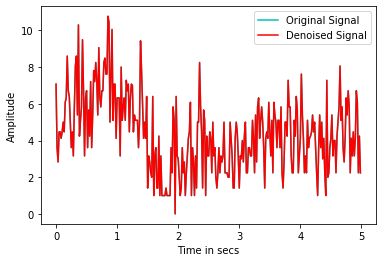

<Figure size 432x288 with 0 Axes>

In [41]:
#### Visualizing the denoised versions ..


one = '/home/surya/Desktop/wifi_sensing/final/1bhk_folder/1_BHK_mag_data/act/input_walk_hall_1.csv'

dsr= 16 
samples = 30000

sliced_list = create_downsample(dsr,samples,one,names)
time_parse_list = total_time_parse(sliced_list)
## This time parse list is for each 

#denoised = denoise(time_parse_list, 0.3 ,title = None, wavelet="db5")
print("The shape after time parsing : ",np.shape(time_parse_list))

n = 300
x = np.arange(n)
x = x/60
a =  np.array(time_parse_list[0])
tmp1 = a[0] ### This contains noise
b = preprocess(a)
tmp2 = b[0] #### This is the denoised version ---

plt.plot(x,tmp1,color = "c",label = "Original Signal")
plt.plot(x,tmp2,color = "r", label = "Denoised Signal")
plt.xlabel("Time in secs")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

plt.savefig('denoise.png', bbox_inches='tight')

[[4.31 4.29 4.29 ... 4.19 4.19 4.26]
 [5.7  5.77 5.84 ... 5.46 5.53 5.61]
 [5.32 5.51 5.72 ... 4.95 5.07 5.18]
 ...
 [4.11 4.22 4.34 ... 3.82 3.91 4.01]
 [3.57 3.62 3.68 ... 3.41 3.46 3.51]
 [3.94 4.02 4.09 ... 3.72 3.79 3.86]]


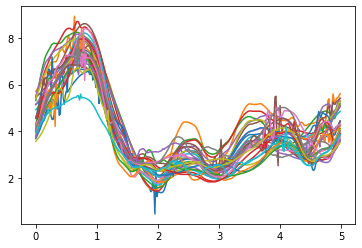

In [11]:
print(b)
for i in range(30):
    plt.plot(x,b[i])

In [43]:
set=[1,2,3,4,5]
print(set[1:])

[2, 3, 4, 5]
